<a href="https://colab.research.google.com/github/Betty929/Betty929.github.io/blob/main/ST449FinalProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Introduction**
Vaccination is an efficient method of preventing the spread of COVID-19, but its efficacy is dependent not only on vaccine availability and delivery, but also on public acceptance, which is focused on public concerns. As a result, the project's aim is to train a tweet sentiment classifier to analyse shifts in public attitudes toward COVID-19 vaccination over time.

This project makes use of two datasets. Aman Miglani's Corona Virus Tagged Data dataset includes tweets about coronavirus that were manually labelled as extremely positive, positive, neutral, negative, and extremely negative. The training dataset contains 41155 tweets, while the testing dataset contains 3797 tweets. The other dataset, uploaded by Ritesh Yadav, includes all unlabeled tweets with the hashtag #Covid19 Vaccine from February 12th to October 22nd, 2020.




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/Colab\ Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
# import the packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
import random
random.seed(100)
from datetime import datetime
import plotly.express as px
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.regularizers import l2


from keras.models import model_from_json

# **2.1   Data Cleaning & EDA**

In [ ]:
# import the dataset for model training from Google drive
url_train = 'https://drive.google.com/file/d/1qi96CKiJVyi4eCLPQGS0oCi-rZTi0Hl1/view?usp=sharing'
url_test = 'https://drive.google.com/file/d/1LRQgxlQD_NM48zbdfTM-6uwR89Bxy1Sj/view?usp=sharing'

def get_df(url):
  path = 'https://drive.google.com/uc?export=download&id='+url.split('/')[-2]
  df = pd.read_csv(path, encoding='latin_1')
  return df

train_df = get_df(url_train)
test_df = get_df(url_test)

# load the tweets dataset
tweets = pd.read_csv('file.csv')


In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,Neutral
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,Positive
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,Positive
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,Positive
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",Extremely Negative


In [ ]:
tweets.head()

,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,tweet,language,mentions,urls,photos,replies_count,retweets_count,likes_count,hashtags,cashtags,link,retweet,quote_url,video,thumbnail,near,geo,source,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest
0,1319174447442448384,1319153697406906369,2020-10-22 12:41:12 India Standard Time,2020-10-22,12:41:12,530,270371054,to_fly_to_live,Flynn Rider,NaN,@ANI Isn't it the best poll promise ever?? Fre...,en,['ani'],[],[],0,0,0,[],[],https://twitter.com/to_fly_to_live/status/1319...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'user_id': '355989081', 'username': 'ANI'}",NaN,NaN,NaN,NaN
1,1319174381503852544,1319174381503852544,2020-10-22 12:40:56 India Standard Time,2020-10-22,12:40:56,530,864189073858084864,utkarshsinha07,Utkarsh Sinha,NaN,Now states shall have wait for thier Vidhan Sa...,en,[],[],[],0,0,0,['biharpolls'],[],https://twitter.com/utkarshsinha07/status/1319...,NaN,https://twitter.com/ani/status/131915369740690...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'user_id': None, 'username': None}",NaN,NaN,NaN,NaN
2,1319174114779643905,1319174114779643905,2020-10-22 12:39:52 India Standard Time,2020-10-22,12:39:52,530,116114711,batolebazi,BATOLEBAZI,NaN,जिस मदारी ने ट्रेन तक नहीं चलाई और तुम पत्नी व...,hi,[],[],['https://pbs.twimg.com/media/Ek6l2igUwAEbmnD....,0,0,1,"['biharpolls', 'covidvaccine']",[],https://twitter.com/BATOLEBAZI/status/13191741...,NaN,NaN,1,https://pbs.twimg.com/media/Ek6l2igUwAEbmnD.jpg,NaN,NaN,NaN,NaN,NaN,NaN,"{'user_id': None, 'username': None}",NaN,NaN,NaN,NaN
3,1319174091232833536,1319172728851591174,2020-10-22 12:39:47 India Standard Time,2020-10-22,12:39:47,530,1249338116,bak_sahil,sahil,NaN,@MisseeMonis They said vaccine for all but not...,en,['misseemonis'],[],[],0,0,0,[],[],https://twitter.com/bak_sahil/status/131917409...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'user_id': '1105377223', 'username': 'MisseeM...",NaN,NaN,NaN,NaN
4,1319174029488476160,1319174029488476160,2020-10-22 12:39:32 India Standard Time,2020-10-22,12:39:32,530,804225890062319617,ivibhatweedy,𝐯𝐢𝐛𝐬 | 🐺,NaN,"BJP really presenting ""free COVID vaccine"" as ...",en,[],[],[],0,0,4,[],[],https://twitter.com/ivibhatweedy/status/131917...,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'user_id': None, 'username': None}",NaN,NaN,NaN,NaN


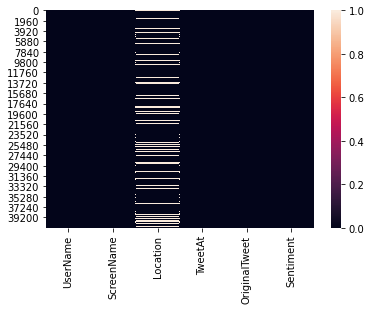

In [ ]:
# check NaN values for training dataset
sns.heatmap(train_df.isnull());

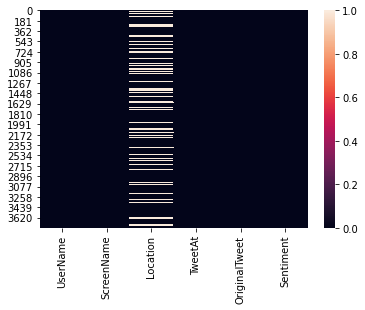

In [ ]:
# check NaN values for testing dataset
sns.heatmap(test_df.isnull());

There are several missing values of Location in both training and testing datasets, but it won't impact the analysis as this field won't be considered in sentiment analysis.

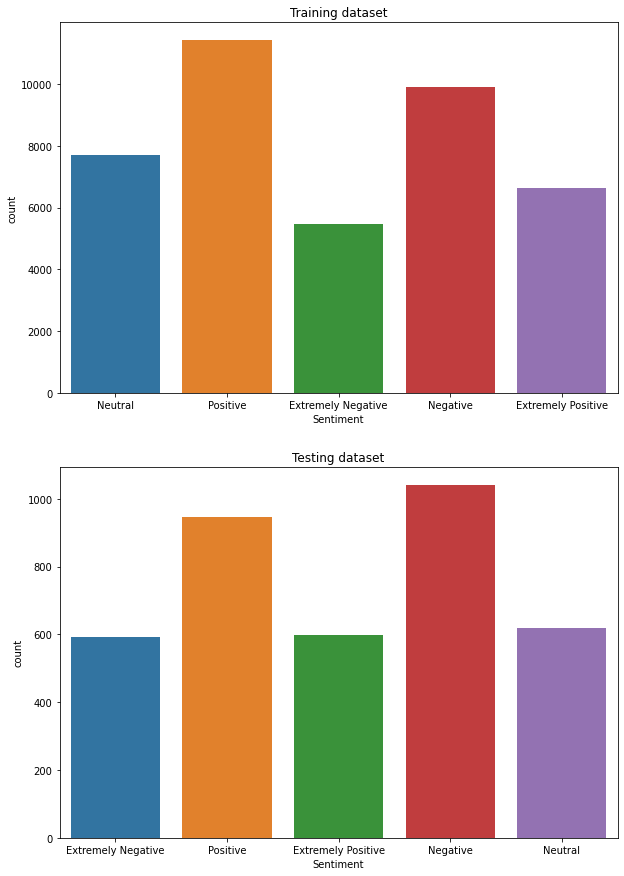

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, figsize = (10, 15))

train = sns.countplot(x="Sentiment", data=train_df, ax=ax1)
ax1.title.set_text('Training dataset')

test = sns.countplot(x="Sentiment", data=test_df, ax=ax2)
ax2.title.set_text('Testing dataset')

In [ ]:
train_df['Sentiment'].unique()

array(['Neutral', 'Positive', 'Extremely Negative', 'Negative',
       'Extremely Positive'], dtype=object)

In [ ]:
def change_senti(sentiment):
  if sentiment == 'Extremely Negative':
    return -1
  elif sentiment == 'Negative':
    return -1
  elif sentiment == 'Neutral':
    return 0
  else:
    return 1

train_df['Sentiment'] = train_df['Sentiment'].apply(lambda x: change_senti(x))
test_df['Sentiment'] = test_df['Sentiment'].apply(lambda x: change_senti(x))

In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,@MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...,0
1,3800,48752,UK,16-03-2020,advice Talk to your neighbours family to excha...,1
2,3801,48753,Vagabonds,16-03-2020,Coronavirus Australia: Woolworths to give elde...,1
3,3802,48754,NaN,16-03-2020,My food stock is not the only one which is emp...,1
4,3803,48755,NaN,16-03-2020,"Me, ready to go at supermarket during the #COV...",-1


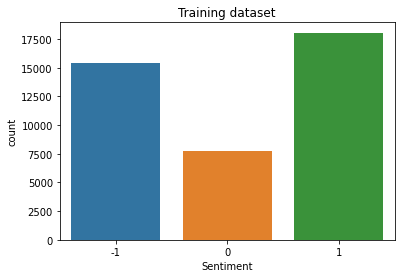

In [ ]:
sns.countplot(x="Sentiment", data=train_df)
plt.title('Training dataset')
plt.show()

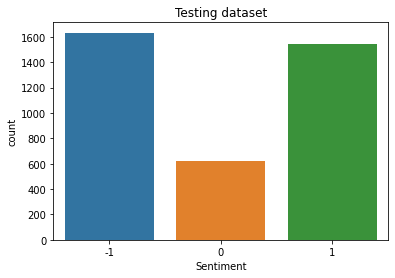

In [ ]:
sns.countplot(x="Sentiment", data=test_df)
plt.title('Testing dataset')
plt.show()

The bar charts above clearly show that the majority of COVID-19-related tweets in the datasets are emotional, with neutral tweets accounting for the smallest proportion.

The sentiment of tweets was re-labeled with positive, neutral, and negative. Both datasets are slightly imbalanced, which could impact the neural network model training.

# **2.2   Text Preparation**
After removing URLs, hashtags, and non-alphabets, the tweets were tokenized and vectorized to turn each text into either a sequence of integers. Then the sequences were padded with 0 to ensure the same shape for further model training.

In [ ]:
# load stop words
nltk.download('stopwords')
stop_word = stopwords.words('english')

# clean the text
def clean_text(text):
    text = re.sub(r"http\S+", "", text) #remove urls
    text=re.sub(r'\S+\.com\S+','',text) 
    text=re.sub(r'\@\w+','',text) #remove mentions
    text =re.sub(r'\#\w+','',text) #remove hashtags
    text = re.sub('[^A-Za-z]', ' ', text.lower()) #remove non-alphabets, and convert to lower case
    text = text.split() #tokenize
    text = " ".join([word for word in text if not word in stop_word])
    return text

train_df['OriginalTweet'] = train_df['OriginalTweet'].apply(lambda x: clean_text(x))
test_df['OriginalTweet'] = test_df['OriginalTweet'].apply(lambda x: clean_text(x))

# tweets dataset
df = tweets[tweets['language'] == 'en'][['date', 'tweet']] # select only date column and English tweets
df['tweet'] = df['tweet'].apply(lambda x: clean_text(x)) # clean the text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
train_df.head()

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment
0,3799,48751,London,16-03-2020,,0
1,3800,48752,UK,16-03-2020,advice talk neighbours family exchange phone n...,1
2,3801,48753,Vagabonds,16-03-2020,coronavirus australia woolworths give elderly ...,1
3,3802,48754,NaN,16-03-2020,food stock one empty please panic enough food ...,1
4,3803,48755,NaN,16-03-2020,ready go supermarket outbreak paranoid food st...,-1


In [ ]:
# extract relevant columns, i.e. OriginalTweet, Sentiment
train = train_df[['OriginalTweet', 'Sentiment']]
x_train = train['OriginalTweet'].copy()
y_train = train['Sentiment'].copy()
y_train = to_categorical(y_train, 3) # convert y to categorical

test = test_df[['OriginalTweet', 'Sentiment']]
x_test = test['OriginalTweet'].copy()
y_test = test['Sentiment'].copy()
y_test = to_categorical(y_test, 3)

In [ ]:
y_train[0:10]

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 0., 1.],
       [0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]], dtype=float32)

In [ ]:
print('The dimension of the training dataset: ', x_train.shape)
print('The dimension of the tweets dataset: ', df.shape)

The dimension of the training dataset:  (41157,)
The dimension of the tweets dataset:  (201030, 2)


In [ ]:
max_len = np.max(df['tweet'].apply(lambda x :len(x))) # maximum length of tweets is used for padding, because there are data in that dataframe
print(max_len)

279


In [ ]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['tweet'])
vocab_length = len(tokenizer.word_index) + 1

x_train1 = tokenizer.texts_to_sequences(x_train)
x_test1 = tokenizer.texts_to_sequences(x_test)
tweet = tokenizer.texts_to_sequences(df['tweet'])

x_train1 = pad_sequences(x_train1, maxlen=max_len, padding='post')
x_test1 = pad_sequences(x_test1, maxlen=max_len, padding='post')
tweet = pad_sequences(tweet, maxlen=max_len, padding='post')

In [ ]:
print("Vocabulary size: {}".format(vocab_length))
print("\nExample:\n")
print("Sentence:\n{}".format(x_train[5]))
print("\nAfter tokenizing & Padding :\n{}".format(x_train1[6]))


Vocabulary size: 57658

Example:

Sentence:
news region first confirmed covid case came sullivan county last week people flocked area stores purchase cleaning supplies hand sanitizer food toilet paper goods reports

After tokenizing & Padding :
[15860  3900  1670  1301  4588  1149  2237  7867  1252    23   263     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0 

# **3.1 CNN Model Building & Training**
**Architecture of the CNN**

The first layer of the CNN network transforms texts into real-valued factures vectors (embedding) that capture the semantic information of the words. This means that an entire tweet can be converted to a matrix of size $s \times d$, where $s$ the number of words in the sentence and $d$ is the dimension of the embedding space. In this project, I chose $s = 279$ and $d = 128$ because of the padding strategy.


The inputs from the embedding layer are then convolved by a convolutional layer with filters of 32 and kernel size of 8 and passed to the next layer. A single convolution involves an input $x: Z\rightarrow R$, where $Z$ is the integer sequences and a kernel function $w: R\rightarrow R$. The convolution operation is defined as  

 \begin{equation} y(t) = f(\sum_{s \in Z}W(s)x(t-s)+b) \end{equation} for $t \in Z$ where $b \in R$ is a bias term and $f(x)$ is a non-linear function, which is chosen to be the relu function. Besides, an L2 regularizer was applied on this layer's kernel and bias to alleviate overfitting. 


After that, each convolution was subjected to a max-pooling operation $y_\max = \max(y)$. For each convolution, the max-pooling operation extracts the most significant feature.


To obtain the classification probabilities, the vector from the max-pooling layer was flattened to 1-dimensional and passed through a completely connected hidden layer of size 256 with both kernal and bias regularizer, which was then passed through a softmax layer.


**CNN Model Training with SGD**

The CNN model was trained via a stochastic gradient descent algorithm with a momentum $\gamma = 0.8$ and decaying learning rate to minimize the cross-categorical loss function with L2 regularizers on both the convolutional layer and the fully connected hidden layer. The momentum $\gamma = 0.8$ was used to enhance the stability of the model by accumulating more information from past gradients to smooth updates. 





In [ ]:
# CNN artchitecture
embed_dim = 128 # to be furhter tuned

model = Sequential()
model.add(Embedding(vocab_length, embed_dim, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=8, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01))) # use L2 regularizer to overcome overfitting
model.add(Dropout(0.3)) # to overcome overfitting
model.add(Dense(3, activation='softmax')) # output layer three classes

print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 279, 128)          7380224   
_________________________________________________________________
conv1d (Conv1D)              (None, 272, 32)           32800     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 136, 32)           0         
_________________________________________________________________
flatten (Flatten)            (None, 4352)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               1114368   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 7

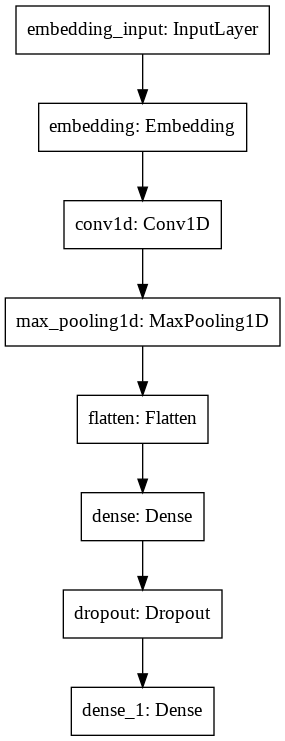

In [ ]:
tf.keras.utils.plot_model(model)

In [ ]:
epochs=100
batch_size = 256
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

# optimizer
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# compile the network
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer=sgd, metrics=['accuracy'])

In [ ]:
# train the network
history1 = model.fit(x_train1, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test1, y_test))

# **3.2 CNN Model Evaluation**

In [ ]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']

loss = history1.history['loss']
val_loss = history1.history['val_loss']

In [ ]:
print(f"Accuracy on training data is: {acc[-1]*100} %")
print(f"Loss {loss[-1]}")

print(f"Accuracy on validation data is: {val_acc[-1]*100} %")
print(f"Loss {val_loss[-1]}")

Accuracy on training data is: 96.07843160629272 %
Loss 0.2814513146877289
Accuracy on validation data is: 82.33280777931213 %
Loss 0.6444941163063049


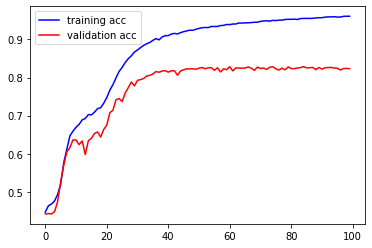

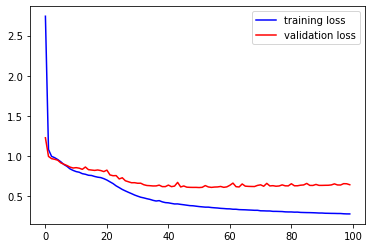

In [ ]:
# Model Accuracy & Loss
epochs = range(len(acc))

plt.plot(epochs, acc,'b',label='training acc')
plt.plot(epochs, val_acc, 'r', label='validation acc')
plt.legend()
plt.show()


plt.plot(epochs, loss,'b',label='training loss')
plt.plot(epochs, val_loss, 'r', label='validation loss')
plt.legend()
plt.show()

In [ ]:
# confusion matrix
pred = np.argmax(model.predict(x_test1), axis=-1)
cm = confusion_matrix(np.argmax(y_test, 1), pred)
cm


array([[ 467,   57,   95],
       [  46, 1298,  202],
       [  91,  180, 1362]])

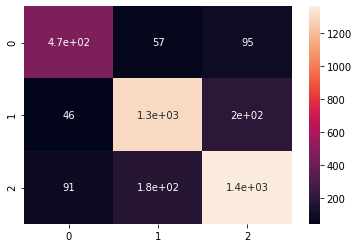

In [ ]:
sns.heatmap(cm,annot=True)
plt.show()

On the training dataset, the CNN model trained with 100 epochs achieves a 96% accuracy rate with a cross-categorical loss of 0.28 and an accuracy rate of 82.33% on testing data with a loss of 0.64. Also, there is no significant overfitting issue according to the line plots above.

# **4.1 LSTM Model Building & Training**
**Architecture of the LSTM**

In addition to the embedding layer, the max-pooling layer, and the dense layer with kernal and bias regularizer similar to CNN, the main building block of the LSTM architecture is the bidirectional LSTM layer that takes into account the whole input sequence by stacking the outputs of a forward and a backward LSTM.  LSTMs are part of the RNN family constructed to deal with sequential data by sharing their internal weights, and they are used to solve the vanishing gradient problem associated with simple RNN by a more complex internal structure that allows LTSMs to remember information for either long or short terms.

The hidden state of an LSTM unit is computed by

\
\begin{equation} f^{(t)} = \sigma(U^fx^{t} + W^fh^{(t-1)}+b^f) \end{equation}
\begin{equation} g^{(t)} = \sigma(U^gx^{t} + W^gh^{(t-1)}+b^g) \end{equation}
\begin{equation} q^{(t)} = \sigma(U^ox^{t} + W^oh^{(t-1)}+b^o) \end{equation}

\
\begin{equation} s^{(t)} = f^{t} {\displaystyle \otimes } s^{(t-1)} + g^{(t)} {\displaystyle \otimes }a(Ux^{(t)}+Uh^{(t-1)}+b) \end{equation}
\begin{equation} h^{(t)} = a(s^{(t)}){\displaystyle \otimes }q^{(t)} \end{equation}
\
where $f^{(t)}$ is the forget gate, $g^{(t)}$ is the input gate, $q^{(t)}$ is the output gate, $s^{(t)}$ is the cell state, $h^{(t)}$ is the regular hidden state, $\sigma$ is the sigmoid function, and ${\displaystyle \otimes }$ is the Hadamard product.

Besides, a dropout layer with probability 40% is added before and after the dense layer to overcome overfitting.

**CNN Model Training with SGD**

The LSTM model was trained via an Adam algorithm, a stochastic gradient descent method that is based on adaptive estimation of first-order and second-order moments, with a constant learning rate of 0.01 to minimize the cross-categorical loss function with L2 regularizers on the fully connected hidden layer. 



In [ ]:
lstm = tf.keras.Sequential([
  tf.keras.layers.Embedding(vocab_length, 128, input_length=max_len),
  tf.keras.layers.Bidirectional(LSTM(256, return_sequences=True, dropout=0.4)),
  tf.keras.layers.GlobalAveragePooling1D(),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(3, activation='softmax')                              
])

# compile the network
lstm.compile(loss=tf.keras.losses.CategoricalCrossentropy(), optimizer='adam', metrics=['accuracy'])

In [ ]:
print(lstm.summary())

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 279, 128)          7380224   
_________________________________________________________________
bidirectional_9 (Bidirection (None, 279, 512)          788480    
_________________________________________________________________
global_average_pooling1d_9 ( (None, 512)               0         
_________________________________________________________________
dropout_19 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_20 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_20 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_21 (Dense)             (None, 3)               

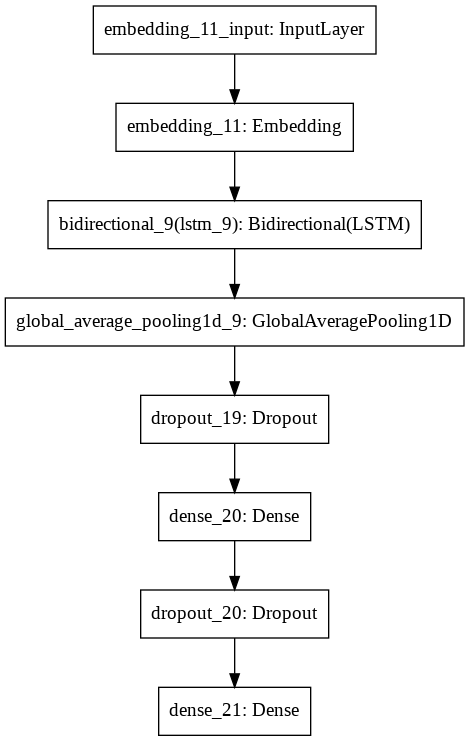

In [ ]:
tf.keras.utils.plot_model(lstm)

In [ ]:
# train the network
history2 = lstm.fit(x_train1, y_train, epochs=10, batch_size= 128, validation_data=(x_test1, y_test))

Epoch 1/10
322/322 [==============================] - 57s 167ms/step - loss: 1.6135 - accuracy: 0.4321 - val_loss: 1.0491 - val_accuracy: 0.4071
Epoch 2/10
322/322 [==============================] - 53s 165ms/step - loss: 1.0057 - accuracy: 0.4602 - val_loss: 0.9822 - val_accuracy: 0.4165
Epoch 3/10
322/322 [==============================] - 53s 164ms/step - loss: 0.9195 - accuracy: 0.5299 - val_loss: 0.9518 - val_accuracy: 0.4734
Epoch 4/10
322/322 [==============================] - 53s 164ms/step - loss: 0.9001 - accuracy: 0.5442 - val_loss: 0.8065 - val_accuracy: 0.5427
Epoch 5/10
322/322 [==============================] - 53s 165ms/step - loss: 0.6423 - accuracy: 0.7289 - val_loss: 0.5178 - val_accuracy: 0.8191
Epoch 6/10
322/322 [==============================] - 53s 164ms/step - loss: 0.3793 - accuracy: 0.8849 - val_loss: 0.4753 - val_accuracy: 0.8449
Epoch 7/10
322/322 [==============================] - 53s 164ms/step - loss: 0.2942 - accuracy: 0.9170 - val_loss: 0.4381 - val_ac

# **4.2 LSTM Model Evaluation**

In [ ]:
acc_lstm = history2.history['accuracy']
val_acc_lstm = history2.history['val_accuracy']

loss_lstm = history2.history['loss']
val_loss_lstm = history2.history['val_loss']

In [ ]:
print(f"Accuracy on training data is: {acc_lstm[-1]*100} %")
print(f"Loss {loss_lstm[-1]}")

print(f"Accuracy on validation data is: {val_acc_lstm[-1]*100} %")
print(f"Loss {val_loss_lstm[-1]}")

Accuracy on training data is: 94.83198523521423 %
Loss 0.1966242492198944
Accuracy on validation data is: 84.33386087417603 %
Loss 0.5319716334342957


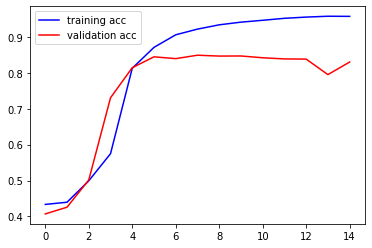

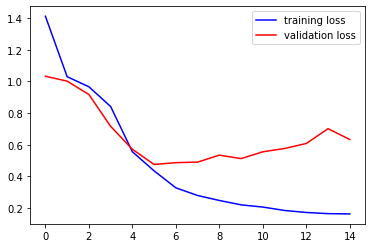

In [ ]:
# Model Accuracy & Loss
epochs = range(len(acc_lstm))

plt.plot(epochs, acc_lstm,'b',label='training acc')
plt.plot(epochs, val_acc_lstm, 'r', label='validation acc')
plt.legend()
plt.show()


plt.plot(epochs, loss_lstm,'b',label='training loss')
plt.plot(epochs, val_loss_lstm, 'r', label='validation loss')
plt.legend()
plt.show() 

In [ ]:
# confusion matrix
pred = np.argmax(lstm.predict(x_test1), axis=-1)
cm = confusion_matrix(np.argmax(y_test, 1), pred)
cm

array([[ 453,   45,  121],
       [  12, 1283,  251],
       [  45,  121, 1467]])

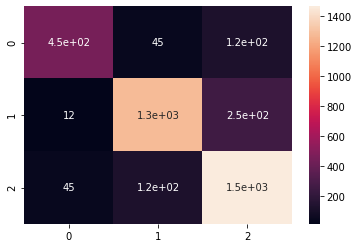

In [ ]:
sns.heatmap(cm,annot=True)
plt.show()

On the training dataset, the LSTM model trained with 10 epochs achieves a 94.8% accuracy rate with a cross-categorical loss of 0.20 and an accuracy rate of 84.3% on testing data with a loss of 0.53. Also, there is a minor overfitting problem as shown in the training and testing loss line plot.

Even though the training accuracy of LSTM is marginally lower than that of the CNN model, the LSTM model trained was more generalised to other datasets, i.e. the testing dataset in this case, than the CNN model trained previously. So the sentiment analysis on the tweets about COVID-19 in section 5 would be done with the LSTM network trained in 4.1.

# **5 Analysis of sentiment in tweets (LSTM)**

In [ ]:
pred = np.argmax(lstm.predict(tweet), axis=-1) # predict the sentiment of tweets with lstm

In [ ]:
df['sentiment'] = pred # combine the sentiemtn with original dataframe

df[df['sentiment'] == 0]['sentiment'] = 'Neutral'
df[df['sentiment'] == 1]['sentiment'] = 'Positive'
df[df['sentiment'] == 2]['sentiment'] = 'Negative'

def change_sentiment(sentiment):
  if sentiment == 0:
    return 'Neutral'
  elif sentiment == 1:
    return 'Positive'
  else:
    return 'Negative'

df['sentiment'] = df['sentiment'].apply(lambda x: change_sentiment(x))
df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

,date,tweet,sentiment
0,2020-10-22,best poll promise ever free covid vaccine vote...,Positive
1,2020-10-22,states shall wait thier vidhan sabha election ...,Negative
3,2020-10-22,said vaccine free covid vaccine new lakhs rs e...,Positive
4,2020-10-22,bjp really presenting free covid vaccine state...,Positive
5,2020-10-22,another dose daily miserablism planet grauniad...,Positive


In [ ]:
# pie chart of sentiment
senti1 = df.groupby(by = 'sentiment', group_keys=False).count()
# senti1.head()

px.pie(senti1, senti1.index, 'tweet', title='Sentiment of Tweets About COVID-19 Vaccine')

From February 12th to October 22nd, 2020, the majority of tweets with the hashtag #Covid19 Vaccine are emotional, which is similar to the training and testing results. Negative sentiment is present in 40.8 percent of vaccine tweets during this time span, which is the highest proportion.

In [ ]:
# convert the date to timestamp
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
df = df.sort_values(by='date')

In [ ]:
df['month'] = df['date'].dt.month # convert to monthly period
monthly = df.groupby(by=['month', 'sentiment'])['tweet'].count().to_frame()
monthly.head()

tweet
month sentiment       
2     Negative      31
      Neutral       10
      Positive      23
3     Negative     958
      Neutral      385

In [ ]:
monthly = monthly.reset_index()

In [ ]:
px.bar(monthly, x='month', y='tweet', color='sentiment', title='Number of Tweets about COVID-19 Vaccine (2020)')

Since the unlabeled tweets dataset covers the period from February 12 to October 22, 2020, only the data from March to September is used to analyze the trend. According to the stacked bar chart above, as time passes, there are more and more discussions about vaccination on Twitter. Even though the negative tweets still accounted for a significant proportion, about 40%, the proportion that neutral and positive tweets took increased over time, indicating that the public acceptance of the COVID-19 vaccination grew with time.

# **6 Conclusion**

The CNN and LSTM classifiers is trained separately with parameters tuned to alleviate the overfitting problems in this project. Among these two neural network architectures, LSTM, which was trained with 10 epochs, outperformed the CNN model with testing accuracy equal to 84.33% and testing loss around 0.532.



**Results of the CNN and LSTM model**

| Model | Training Accuracy | Training Loss | Testing Accuracy | Testing Loss | Epoches |
| ------ | ----------------- | -------------- | ----------------- | ------------ | ------- |
|CNN|96.08%|0.281|82.33%|0.644|100|
|LSTM|94.83%|0.1966|84.33%|0.532|10|


\

As for the sentiment embedded in tweets about COVID-19 vaccination, even though the negative tweets still take a significant component of the total, the attitude, assessed with the LSTM classifier, towards vaccination on Twitter improved over time. However, misclassification may also occur as a result of the accuracy rate of 84.3% as shown in the confusion matrix in section 4.2.

For future work, the word embedding can be pre-trained with a huge amount of unlabelled tweets to be later used in the CNN and LSTM architecure. There are several unsupervised machine learning algorithms that can be used to train the word embedding, such as Google's Word2vec and Facebook's FastText. This requires a large amount of tweets corpus and the performance of the model with pre-trained word embeddings need to be further examined.

# **7 References**
1. Brownlee, J. (2017). How to Develop a Deep Convolutional Neural Network for Sentiment Analysis (Text Classification). [online] Machine Learning Mastery. Available at: https://machinelearningmastery.com/develop-word-embedding-model-predicting-movie-review-sentiment/.
2. Word embeddings (2019). Word embeddings | TensorFlow Core. [online] TensorFlow. Available at: https://www.tensorflow.org/tutorials/text/word_embeddings.
3. TensorFlow. (n.d.). Word2Vec | TensorFlow Core. [online] Available at: https://www.tensorflow.org/tutorials/text/word2vec.
4. Nogueira, C., Santos, D. and Gatti, M. (2014). Deep Convolutional Neural Networks for Sentiment Analysis of Short Texts. [online] , pp.69–78. Available at: https://www.aclweb.org/anthology/C14-1008.pdf [Accessed 11 Mar. 2021].
5. Cliche Bloomberg, M. (n.d.). BB twtr at SemEval-2017 Task 4: Twitter Sentiment Analysis with CNNs and LSTMs. [online] . Available at: https://arxiv.org/pdf/1704.06125.pdf [Accessed 11 Mar. 2021].
6. SteelFisher, G.K., Blendon, R.J. and Caporello, H. (2021). An Uncertain Public — Encouraging Acceptance of Covid-19 Vaccines. New England Journal of Medicine.
7. Li, Q., Shah, S., Liu, X. and Nourbakhsh, A. (n.d.). Data Sets: Word Embeddings Learned from Tweets and General Data. [online] . Available at: https://arxiv.org/ftp/arxiv/papers/1708/1708.03994.pdf [Accessed 18 Apr. 2021].

‌